## Arquivos

**Training Data**

- ISIC_2019_Training_Input.zip
- 25,331 imagens jpg


- ISIC_2019_Training_Metadata.csv
- 25,331 registros de metadados com idade, sexo, anatomia geral e identificador de lesão


- ISIC_2019_Training_GroundTruth.csv
- 25,331 registros de diganósticos de lesões, um para cada imagem (labels)

## Dicionário de Dados

O objetivo do dataset ISIC 2019 é classificar imagens dermatoscópicas entre nove categorias diferentes de diagnóstico:

**Classes**

- Melanoma
- Melanocytic nevus
- Basal cell carcinoma
- Actinic keratosis
- Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- Dermatofibroma
- Vascular lesion
- Squamous cell carcinoma
- None of the others

**Legenda:**
    
- MEL = Melanoma
- NV = Melanocytic nevus
- BCC = Basal cell carcinoma
- AK = Actinic keratosis
- BKL = Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF = Dermatofibroma
- VASC = Vascular lesion
- SCC = Squamous cell carcinoma
- UNK = None of the others

Esse é o conteúdo do arquivo **ISIC_2019_Training_GroundTruth.csv**, para cada imagem.

## Carregando os Pacotes

In [4]:
# Imports 

# Imports para manipulação e visualização de dados
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Imports para manipulação de imagens
import os 
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split

# Imports para cálculo de métricas e utilitários
import itertools
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Imports para Deep Learning
import plaidml
import plaidml.keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback
from keras.utils.np_utils import to_categorical
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%matplotlib inline

2022-04-20 12:59:06.088693: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Using TensorFlow backend.


In [5]:
### Keras Backend
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Versões Usadas

In [6]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [7]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

keras     : 2.2.4
matplotlib: 3.3.4
pandas    : 1.0.3
sklearn   : 1.0.2
tensorflow: 2.3.1
numpy     : 1.18.5
PIL       : 9.0.0
sys       : 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]



## Primeira Etapa

### Carregando e Compreendendo os Dados

In [8]:
# Carregando o conjunto de dados (imagem/classe)
dataset = pd.read_csv('/media/datasets/IAMED/Cap03/ISIC_2019_Training_GroundTruth.csv')

In [9]:
# Visualiza o dataset
dataset

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Legenda:**
    
- MEL = Melanoma
- NV = Melanocytic nevus
- BCC = Basal cell carcinoma
- AK = Actinic keratosis
- BKL = Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF = Dermatofibroma
- VASC = Vascular lesion
- SCC = Squamous cell carcinoma
- UNK = None of the others

### Limpeza e Transformação dos Dados

In [10]:
# Renomeando a columa com o id da imagem
dataset.rename(columns = {'image':'image_id'}, inplace = True)

In [11]:
# Visualização dos dados
dataset.head()

,image_id,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Nova coluna com os valores da coluna 'UNK'
dataset['tipo_cancer'] = dataset['UNK']

In [13]:
# Loop por cada item do dataset
for index, row in dataset.iterrows():
    
    # Se encontrar o valor 1.0 na linha, pega o índice da coluna e atribui como valor da nova coluna criada
    dataset['tipo_cancer'][index] = (row == 1.0).idxmax(axis = 1)

In [14]:
# Visualização os dados
dataset.tail(10)

,image_id,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,tipo_cancer
25321,ISIC_0073240,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25322,ISIC_0073241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
25323,ISIC_0073244,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25324,ISIC_0073245,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25325,ISIC_0073246,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,BCC
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
25330,ISIC_0073254,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BKL


Será que precisamos de tantas colunas? Perceba que cada linha tem o valor 1.0 em apenas uma coluna, indicando que aquela imagem tem aquela classe. Vamos simplificar nosso dataset.

In [15]:
# Não precisamos mais das outras colunas e podemos remover
dataset = dataset.drop(['MEL', 'NV', 'AK', 'BCC', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis = 1)

In [16]:
# Visualização dos dados
dataset.head()

,image_id,tipo_cancer
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


Precisamos realmente de todas as classes para o projeto? Temos dados suficientes para isso?

In [17]:
# Valores únicos
dataset['tipo_cancer'].unique()

array(['NV', 'MEL', 'BKL', 'DF', 'SCC', 'BCC', 'VASC', 'AK'], dtype=object)

**Legenda:**
    
- MEL = Melanoma
- NV = Melanocytic nevus
- BCC = Basal cell carcinoma
- AK = Actinic keratosis
- BKL = Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- DF = Dermatofibroma
- VASC = Vascular lesion
- SCC = Squamous cell carcinoma
- UNK = None of the others

In [18]:
# Shape
dataset.shape

(25331, 2)

In [19]:
# Vejamos o total de registros por classe
dataset['tipo_cancer'].value_counts()

NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: tipo_cancer, dtype: int64

Removeremos os registros das classes com menor número de amostras. Caso mantivessem todas as classes, teriamos problemas no balanceamento, não poderiamos aplicar o Oversampling pois teriamos que gerar muitas imagens sintéticas, podendo influenciar o modelo negativamente e não poderiamos aplicar o Undersampling pois diminuiriamos de mais os números de amostras podendo fazer com que o modelo não aprenda.

In [20]:
# Remove os registros das classes com menos amostras
dataset = dataset[dataset.tipo_cancer != 'DF']
dataset = dataset[dataset.tipo_cancer != 'VASC']
dataset = dataset[dataset.tipo_cancer != 'SCC']
dataset = dataset[dataset.tipo_cancer != 'AK']
dataset = dataset[dataset.tipo_cancer != 'UNK']

In [21]:
# Verificamos a proporção de registros por classe
dataset.tipo_cancer.value_counts()

NV     12875
MEL     4522
BCC     3323
BKL     2624
Name: tipo_cancer, dtype: int64

In [22]:
# Shape
dataset.shape

(23344, 2)

Label Encoding da variável categórica: convertemos o texto para um valor numérico correspondente e gravamos em outra coluna.

In [23]:
# Visualização dos dados
dataset.head()

,image_id,tipo_cancer
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [24]:
# Label encoding
dataset['tipo_cancer_idx'] = pd.Categorical(dataset['tipo_cancer']).codes

In [25]:
# Visualização dos dados
dataset.head()

,image_id,tipo_cancer,tipo_cancer_idx
0,ISIC_0000000,NV,3
1,ISIC_0000001,NV,3
2,ISIC_0000002,MEL,2
3,ISIC_0000003,NV,3
4,ISIC_0000004,MEL,2


In [26]:
# Visualização dos dados
dataset['tipo_cancer_idx'].unique()

array([3, 2, 1, 0], dtype=int8)

### Limpeza e Transformação das Imagens

In [27]:
# Carregando a lista de imagens para treinamento
imagens = os.listdir('/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/')

In [28]:
# Listar algumas imagens
imagens[1:5]

['ISIC_0066102.jpg',
 'ISIC_0058433.jpg',
 'ISIC_0057942.jpg',
 'ISIC_0024315.jpg']

In [29]:
# Tamanho da lista de imagens
len(imagens)

25333

In [30]:
# Função para extrair o caminho de cada imagem, concatenar com o nome da imagem no dataframe 
# e adicionar a extensão jpg
def extrai_path_imagem(x):
    file = x + '.jpg'
    return os.path.join('/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/', file)

In [31]:
# Aplicamos a função à coluna imagem_id e gravamos o resultado na coluna imagem
dataset['imagem'] = dataset['image_id'].apply(extrai_path_imagem)

In [32]:
# Visualização dos dados
dataset.head()

,image_id,tipo_cancer,tipo_cancer_idx,imagem
0,ISIC_0000000,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
1,ISIC_0000001,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
2,ISIC_0000002,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
3,ISIC_0000003,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
4,ISIC_0000004,MEL,2,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


### Balanceamento de Classe para Classificação Multiclasse

As classes estão desbalanceadas, ou seja, temos mais imagens de uma classe que outra.

In [33]:
# Shape
dataset.shape

(23344, 4)

In [34]:
# Número total de registros
dataset.shape[0]

23344

In [35]:
# Verificamos a proporção de registros por classe
dataset.tipo_cancer.value_counts()

NV     12875
MEL     4522
BCC     3323
BKL     2624
Name: tipo_cancer, dtype: int64

In [36]:
# Verificamos a proporção de registros por classe em valor percentual
dataset.tipo_cancer.value_counts() / dataset.shape[0] * 100

NV     55.153358
MEL    19.371145
BCC    14.234921
BKL    11.240576
Name: tipo_cancer, dtype: float64

Se aplicarmos o Oversampling, teriamos que gerar muitas imagens sintéticas e poderiamos acabar influenciando o modelo de maneira negativa.
>Com isso vamos aplicar o Undersampling. Começaremos separando os registros da classe NV de todas as demais classes.

In [37]:
# Registros da classe NV
df_nv = dataset[dataset['tipo_cancer'] == 'NV']

In [38]:
# Registros das demais classes
df_no_nv = dataset[dataset['tipo_cancer'] != 'NV']

In [39]:
# Shuffle
df_nv = shuffle(df_nv)

In [40]:
# Total de registros da classe NV
df_nv.count()

image_id           12875
tipo_cancer        12875
tipo_cancer_idx    12875
imagem             12875
dtype: int64

Vamos extrair 4500 registros da classe NV para manter o dataset equilibrado entre todas as classes. Vamos aplicar o Undersampling, ou seja, vamos reduzir a classe majoritária.

In [41]:
# Cria o novo dataframe com 4500 registros
df_nv = df_nv.head(4500)

In [42]:
# Reset do índice
df_nv = df_nv.reset_index(drop = True)

In [43]:
# Concatenamos os registros da classe NV com os registros das demais classes
dataset_final = pd.concat([df_nv, df_no_nv])

In [44]:
# Shape
dataset_final.shape

(14969, 4)

In [45]:
# Verifica a proporção de classe
dataset_final.tipo_cancer.value_counts()

MEL    4522
NV     4500
BCC    3323
BKL    2624
Name: tipo_cancer, dtype: int64

In [46]:
# Verificamos a proporção de registros por classe em valor percentual
dataset_final.tipo_cancer.value_counts() / dataset_final.shape[0] * 100

MEL    30.209099
NV     30.062128
BCC    22.199212
BKL    17.529561
Name: tipo_cancer, dtype: float64

### Preparação das Amostras de Teste

Ok. Já temos o dataset com um balanceamento bem mais adequado do que estava antes. Nosso próximo passo é separar algumas amostras para avaliar o modelo treinado.

In [47]:
# Shape
dataset_final.shape

(14969, 4)

In [48]:
# Registros de teste para a classe NV
df_nv = dataset_final[dataset_final['tipo_cancer'] == 'NV']
df_nv = shuffle(df_nv)
df_nv = df_nv.head(100)
df_nv = df_nv.reset_index(drop = True)

In [49]:
# Registros de teste para a classe MEL
df_mel = dataset_final[dataset_final['tipo_cancer'] == 'MEL']
df_mel = shuffle(df_mel)
df_mel = df_mel.head(100)
df_mel = df_mel.reset_index(drop = True)

In [50]:
# Registros de teste para a classe BCC
df_bcc = dataset_final[dataset_final['tipo_cancer'] == 'BCC']
df_bcc = shuffle(df_bcc)
df_bcc = df_bcc.head(100)
df_bcc = df_bcc.reset_index(drop = True)

In [51]:
# Registros de teste para a classe BKL
df_bkl = dataset_final[dataset_final['tipo_cancer'] == 'BKL']
df_bkl = shuffle(df_bkl)
df_bkl = df_bkl.head(100)
df_bkl = df_bkl.reset_index(drop = True)

In [52]:
# Concatenamos as amostras de teste em um novo dataframe
df_teste = pd.concat([df_bcc, df_bkl, df_mel, df_nv])

In [53]:
# "Embaralhamos" os dados
df_teste = shuffle(df_teste)

In [54]:
# E não podemos esquecer do reset do índice
df_teste = df_teste.reset_index(drop = True)

In [55]:
# Checamos a proporção de registros por classe
df_teste.tipo_cancer.value_counts()

MEL    100
BKL    100
BCC    100
NV     100
Name: tipo_cancer, dtype: int64

In [56]:
# E verificamos os dados
df_teste.head()

,image_id,tipo_cancer,tipo_cancer_idx,imagem
0,ISIC_0054161,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
1,ISIC_0060875,BKL,1,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
2,ISIC_0057424,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
3,ISIC_0031354,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
4,ISIC_0028674,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


### Preparação das Amostras de Treino

Precisamos então preparar o dataset de treino, filtrando do dataset original todas as imagens que foram colocadas no dataset de teste.

In [57]:
# Criando o dataset de treino
df_treino = dataset_final

In [58]:
# Shape
dataset_final.shape

(14969, 4)

In [59]:
# Shape
df_treino.shape

(14969, 4)

In [60]:
# Shape
df_teste.shape

(400, 4)

In [61]:
# Cria uma lista de valores das colunas
keys = list(dataset_final.columns.values)

In [62]:
# Define os índices dos datasets de treino e teste
i1 = df_treino.set_index(keys).index
i2 = df_teste.set_index(keys).index

In [63]:
# E agora filtramos o dataset de treino, com todas as imagens que não estão no dataset de teste
df_treino = df_treino[~i1.isin(i2)]

In [64]:
# Shape
df_treino.shape

(14569, 4)

In [65]:
# Verificamos uma imagem de teste
df_teste['imagem'][10]

'/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/ISIC_0060656.jpg'

In [67]:
# Checamos se a imagem de teste está no dataset de treino. O resultado deve ser False
'/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/ISIC_0060656.jpg' in df_treino.imagem.values

False

In [68]:
# E não podemos esquecer do reset do índice
df_treino = df_treino.reset_index(drop = True)

In [69]:
# Visualiza os dados
df_treino.head()

,image_id,tipo_cancer,tipo_cancer_idx,imagem
0,ISIC_0070862,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
1,ISIC_0032317,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
2,ISIC_0027792,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
3,ISIC_0067474,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...
4,ISIC_0011157,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...


### Redimensionamento das Imagens

Trabalhar com imagens maiores consequentemente leva muito mais tempo no treinamento (correndo o risco de estourar a memória da GPU), podemos reduzir o tamanho das imagens para acelerar o treinamento e usar os recursos computacionais disponíveis.

In [70]:
# Verificando a imagem
df_treino['imagem'][10]

'/media/datasets/IAMED/Cap03/ISIC_2019_Training_Input/ISIC_0025749.jpg'

In [71]:
# Vamos buscar uma imagem qualquer no dataset de treino
caminho_imagem =  df_treino['imagem'][10]

In [72]:
# Carregamos a imagem com a função Image.open() do pacote PIL
imagem = Image.open(caminho_imagem)

In [73]:
# Extraímos o tamanho da imagem em pixels
imagem.size

(600, 450)

In [74]:
# Extraímos a largura
imagem.width

600

In [75]:
# Extraímos a altura
imagem.height

450

### Redimensionamento das Imagens de Treino.

In [76]:
%%time
df_treino['imagem_res'] = df_treino['imagem'].map(lambda x: np.asarray(Image.open(x).resize((128, 128))))

CPU times: user 2min 46s, sys: 1.28 s, total: 2min 48s
Wall time: 2min 49s


In [77]:
# Ajustando o índice
df_treino.set_index("image_id", inplace = True)

In [78]:
# Shape do dataframe
df_treino.shape

(14569, 4)

In [79]:
# Shape de uma imagem
df_treino.imagem_res[0].shape

(128, 128, 3)

In [80]:
# Visualização dos dados
df_treino.head()

,tipo_cancer,tipo_cancer_idx,imagem,imagem_res
image_id,,,,
ISIC_0070862,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[176, 172, 168], [178, 175, 170], [180, 176,..."
ISIC_0032317,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[240, 154, 144], [238, 149, 132], [235, 145,..."
ISIC_0027792,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[225, 145, 152], [226, 146, 155], [229, 148,..."
ISIC_0067474,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[118, 118, 123], [122, 121, 127], [125, 124,..."
ISIC_0011157,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[213, 217, 203], [212, 214, 200], [212, 216,..."


### Redimensionamento das Imagens de Teste.

In [81]:
%%time
df_teste['imagem_res'] = df_teste['imagem'].map(lambda x: np.asarray(Image.open(x).resize((128, 128))))

CPU times: user 4.55 s, sys: 28 ms, total: 4.58 s
Wall time: 4.63 s


In [82]:
# Ajustando o índice
df_teste.set_index("image_id", inplace = True)

In [83]:
# Shape de uma imagem
df_teste.shape

(400, 4)

In [84]:
# Shape de uma imagem
df_teste.imagem_res[0].shape

(128, 128, 3)

In [85]:
# Visualização dos dados
df_teste.head()

,tipo_cancer,tipo_cancer_idx,imagem,imagem_res
image_id,,,,
ISIC_0054161,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
ISIC_0060875,BKL,1,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[139, 121, 114], [143, 125, 118], [138, 119,..."
ISIC_0057424,BCC,0,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[0, 2, 0], [0, 2, 0], [0, 2, 0], [0, 2, 0], ..."
ISIC_0031354,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[106, 65, 52], [108, 65, 46], [101, 57, 36],..."
ISIC_0028674,NV,3,/media/datasets/IAMED/Cap03/ISIC_2019_Training...,"[[[190, 100, 113], [189, 99, 115], [191, 102, ..."


### Visualização das Imagens

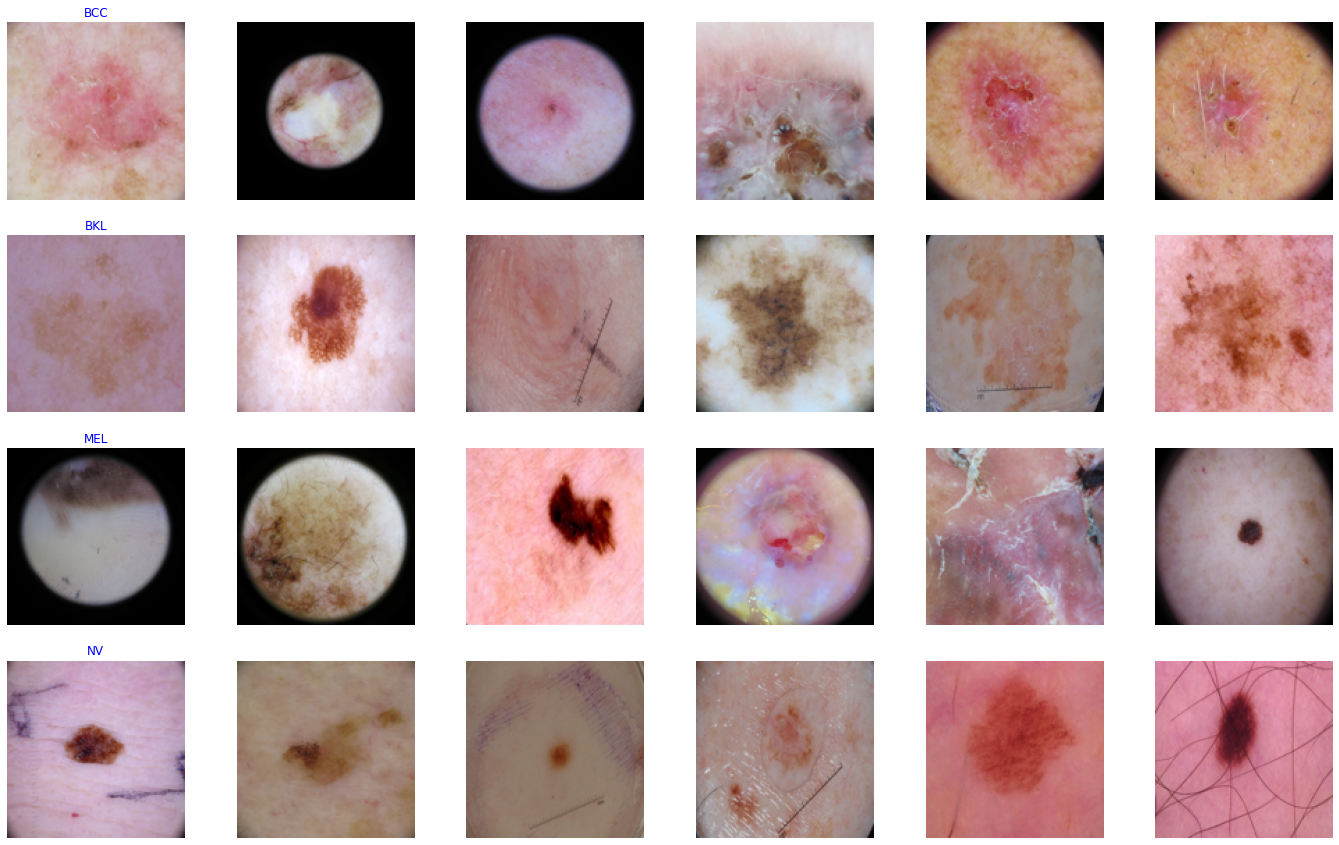

In [86]:
# Plot

# Número de amostras
n_samples = 6

# Figura e subplots
fig, m_axs = plt.subplots(4, n_samples, figsize = (4 * n_samples, 3 * 5))

# Loop pelos eixos
# Retorna o nome da classe e o número de imagens da classe
for n_axs, (type_name, type_rows) in zip(m_axs, df_treino.sort_values(['tipo_cancer']).groupby('tipo_cancer')):
    
    # Título de cada classe
    n_axs[0].set_title(type_name, color = 'blue')
    
    # Loop pelas amostras 
    # Retiramos amostras randômicas do total de imagens
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):
        c_ax.imshow(c_row['imagem_res'])
        c_ax.axis('off')

>Vamos checar se todas as dimensões estão corretas e avançamos para a próxima etapa.

In [87]:
# Total de amostras em treino
df_treino['imagem_res'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    14569
Name: imagem_res, dtype: int64

In [88]:
# Amostras por classe em treino
df_treino.tipo_cancer.value_counts()

MEL    4422
NV     4400
BCC    3223
BKL    2524
Name: tipo_cancer, dtype: int64

In [89]:
# Total de amostras em teste
df_teste['imagem_res'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    400
Name: imagem_res, dtype: int64

In [90]:
# Amostras por classe em teste
df_teste.tipo_cancer.value_counts()

MEL    100
BKL    100
BCC    100
NV     100
Name: tipo_cancer, dtype: int64

### Divisão em Dados de Treino, Validação e Teste

### Treino e Teste

In [91]:
# Deixamos os registros aleatórios
df_treino = shuffle(df_treino)
df_teste = shuffle(df_teste)

In [92]:
# Colocamos as colunas com o valor numérico de cada classe em y (variável target)
y_treino = df_treino['tipo_cancer_idx']
y_teste = df_teste['tipo_cancer_idx']

In [93]:
# Shape em treino
y_treino.shape

(14569,)

In [94]:
# Shape em teste
y_teste.shape

(400,)

In [95]:
# Proporção de classe em treino
y_treino.value_counts()

2    4422
3    4400
0    3223
1    2524
Name: tipo_cancer_idx, dtype: int64

In [96]:
# Proporção de classe em teste
y_teste.value_counts()

3    100
2    100
1    100
0    100
Name: tipo_cancer_idx, dtype: int64

In [97]:
# Convertemos y para o tipo categórico
y_treino = to_categorical(y_treino, num_classes = 4)
y_teste = to_categorical(y_teste, num_classes = 4)

In [98]:
# Shape em treino
y_treino.shape

(14569, 4)

In [99]:
# Shape em teste
y_teste.shape

(400, 4)

A variável de saída (classe) está pronta. Vamos preparar a variável de entrada (imagens).

In [100]:
# Extraímos somente as imagens do dataframe, convertemos para lista e então criamos o array NumPy
x_treino = np.asarray(df_treino['imagem_res'].tolist())
x_teste = np.asarray(df_teste['imagem_res'].tolist())

### Normalização

In [101]:
# Calculamos média e desvio padrão para normalizar as imagens de treino
x_treino_mean = np.mean(x_treino)
x_treino_std = np.std(x_treino)

In [102]:
# Calculamos média e desvio padrão para normalizar as imagens de teste
x_teste_mean = np.mean(x_teste)
x_teste_std = np.std(x_teste)

Os valores de pixels estão em unidades diferentes. A Normalização vai colocar os pixels na mesma escala.

In [103]:
# Normalização em treino
x_treino = (x_treino - x_treino_mean) / x_treino_std

In [104]:
# Normalização em teste
x_teste = (x_teste - x_teste_mean) / x_teste_std

In [105]:
# Shape em treino
x_treino.shape

(14569, 128, 128, 3)

In [106]:
# Shape em teste
x_teste.shape

(400, 128, 128, 3)

### Dados de Treino e Validação.

Com os dados de treino e teste gerados, utilizamos o train_test_split para gerar a partir dos dados treino, um novo conjunto de dados de treino e um novo conjunto de dados para validação do modelo.

In [107]:
# Divisão em treino e validação
x_treino, x_valid, y_treino, y_valid = train_test_split(x_treino, 
                                                        y_treino, 
                                                        test_size = 0.20, 
                                                        random_state = 42)

In [108]:
# Shape treino/validação
print("Shape de x_treino =", x_treino.shape)
print("Shape de y_treino =", y_treino.shape)
print("Shape de x_valid =", x_valid.shape)
print("Shape de y_valid =", y_valid.shape)

Shape de x_treino = (11655, 128, 128, 3)
Shape de y_treino = (11655, 4)
Shape de x_valid = (2914, 128, 128, 3)
Shape de y_valid = (2914, 4)


In [109]:
# Shape teste
print("Shape de x_teste =", x_teste.shape)
print("Shape de y_teste =", y_teste.shape)

Shape de x_teste = (400, 128, 128, 3)
Shape de y_teste = (400, 4)


## Segunda Etapa

### Construção do Modelo

Para este projeto, vamos usar a arquitetura InceptionV3 com um modelo pré-treinado oferecido pelo Keras e então adicionaremos algumas camadas ao final para customizar as saídas da rede.

### Hiperparâmetros

In [174]:
# Hiperparâmetros

# Shape das imagens
input_shape = (128, 128, 3)

# Número de classes a prever
num_classes = 4 

# Número de épocas de treinamento
epochs = 50

# Tamanho do batch
batch_size = 16

# Taxa de aprendizado
lr_param = 0.00001

# Parâmetros beta
beta_1_param = 0.9
beta_2_param = 0.999

# Decay
decay_param = 0.0

# Passos por época
steps_per_epoch_param = x_treino.shape[0] // batch_size

### Modelo

In [175]:
# Criamos o modelo base
modelo_base = tf.keras.applications.InceptionV3(weights = 'imagenet', 
                                                include_top = False, 
                                                input_shape = input_shape)

In [176]:
# Sumário do modelo base
modelo_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 63, 63, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 63, 63, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [177]:
# Adicionamos nossas camadas ao modelo_base

# Cria a sequência de camadas
add_model = Sequential()

# Adiciona primeiro o modelo base
add_model.add(modelo_base)

# Precisamos de uma camada global de Pooling
add_model.add(GlobalAveragePooling2D())

# Dropout para regularização e evitar overfitting
add_model.add(Dropout(0.5))

# 1º Camada densa
add_model.add(Dense(32, activation = 'relu'))

# 2º Camada densa
add_model.add(Dense(64, activation = 'relu'))

# Camada densa na camada final com ativação softmax para previsão das probabilidades das classes
add_model.add(Dense(num_classes, activation = 'softmax'))

In [178]:
# Cria o modelo final
modelo_final = add_model

In [179]:
# Sumário do modelo final
modelo_final.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                65568     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 21,870,724
Trainable params: 21,836,292
Non-trainable params: 34,432
_____________________________________

### Otimizador

In [180]:
# Cria o otimizador
otimizador = Adam(lr = lr_param)
                  #beta_1 = beta_1_param, 
                  #beta_2 = beta_2_param, 
                  #epsilon = None, 
                  #decay = decay_param, 
                  #amsgrad = False)

In [181]:
# Compila o modelo com o otimizador, função de custo e métricas que serão extraídas no treinamento
modelo_final.compile(optimizer = otimizador, 
                     loss = "categorical_crossentropy", 
                     metrics = ["accuracy"])

### Callbacks

In [182]:
# Regra para a redução da taxa de aprendizado
reduz_taxa_aprendizado = ReduceLROnPlateau(monitor = 'val_loss', 
                                           patience = 5, 
                                           verbose = 1, 
                                           factor = 0.5,
                                           mode = 'min',
                                           min_lr = 0.000001)

In [183]:
# Definimos um checkpoint para verificar regularmente se a perda em validação diminuiu
# Se a performance melhorar em validação salvamos o modelo
# Podemos ainda optar por salvar o modelo a cada número de épocas
checkpoint = ModelCheckpoint('modelo/skin_model.h5', 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'min')

In [184]:
# Cria os callbacks que serão usados no treinamento
callbacks_list = [checkpoint, reduz_taxa_aprendizado]

### Gerador de dados

In [185]:
# Gerador de dados para o treinamento
datagen = ImageDataGenerator(featurewise_center = False,  
                             samplewise_center = False,  
                             featurewise_std_normalization = False,  
                             samplewise_std_normalization = False, 
                             zca_whitening = False,  
                             rotation_range = 10,  
                             zoom_range = 0.1, 
                             width_shift_range = 0.1,  
                             height_shift_range = 0.1,  
                             horizontal_flip = False,  
                             vertical_flip = False) 

### Treinamento 

In [186]:
%%time

print("\nIniciando o Treinamento do Modelo.\n")

history = modelo_final.fit(datagen.flow(x_treino, 
                                        y_treino, 
                                        batch_size = batch_size),
                           epochs = epochs, 
                           validation_data = (x_valid, y_valid),
                           verbose = 1, 
                           steps_per_epoch = steps_per_epoch_param, 
                           callbacks = [reduz_taxa_aprendizado])

print("\nTreinamento Concluído.\n")


Iniciando o Treinamento do Modelo.

Epoch 1/50
728/728 [==============================] - 38s 52ms/step - loss: 1.3132 - accuracy: 0.3798 - val_loss: 1.1885 - val_accuracy: 0.4904
Epoch 2/50
728/728 [==============================] - 37s 50ms/step - loss: 1.1665 - accuracy: 0.4877 - val_loss: 1.0646 - val_accuracy: 0.5477
Epoch 3/50
728/728 [==============================] - 37s 51ms/step - loss: 1.0885 - accuracy: 0.5364 - val_loss: 1.0131 - val_accuracy: 0.5700
Epoch 4/50
728/728 [==============================] - 37s 50ms/step - loss: 1.0163 - accuracy: 0.5744 - val_loss: 0.9557 - val_accuracy: 0.6060
Epoch 5/50
728/728 [==============================] - 37s 50ms/step - loss: 0.9715 - accuracy: 0.5914 - val_loss: 0.9098 - val_accuracy: 0.6290
Epoch 6/50
728/728 [==============================] - 37s 51ms/step - loss: 0.9310 - accuracy: 0.6095 - val_loss: 0.8704 - val_accuracy: 0.6407
Epoch 7/50
728/728 [==============================] - 37s 51ms/step - loss: 0.8963 - accuracy: 0.62

## Terceira Etapa

### Avaliação do Modelo

In [187]:
# Histórico de treinamento
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

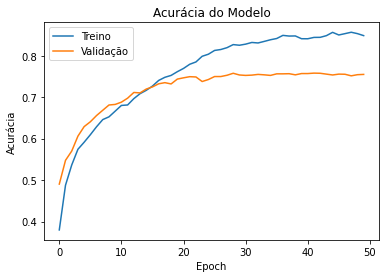

In [188]:
# Plot da Acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc = 'upper left')
plt.show()

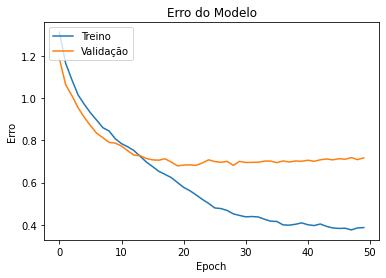

In [189]:
# Plot do Erro
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Erro do Modelo')
plt.ylabel('Erro')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc = 'upper left')
plt.show()

In [190]:
# Calcula as métricas com dados de validação para comparar com a performance em teste
loss_v, accuracy_v = modelo_final.evaluate(x_valid, y_valid, verbose = 1)

92/92 [==============================] - 2s 21ms/step - loss: 0.7175 - accuracy: 0.7550


In [217]:
# Calcula as métricas com dados de teste
loss, accuracy = modelo_final.evaluate(x_teste, y_teste, verbose = 1)

13/13 [==============================] - 0s 20ms/step - loss: 0.6381 - accuracy: 0.8125


In [218]:
print("Acurácia em Validação = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

Acurácia em Validação = 0.754976  ;  loss_v = 0.717483


In [219]:
print("Acurácia em Teste = %f  ;  loss = %f" % (accuracy, loss))

Acurácia em Teste = 0.812500  ;  loss = 0.638146


Vamos fazer previsões com o modelo em dados de teste!

In [224]:
# Previsões do modelo com dados de teste
Y_pred = modelo_final.predict(x_teste)

In [225]:
# Converte as previsões de classe em teste para One-hot encoding
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

In [226]:
# Extrai o label real das classes
Y_true_classes = np.argmax(y_teste, axis = 1) 

In [227]:
# Criamos a Matriz de Confusão
print(confusion_matrix(Y_true_classes, Y_pred_classes))

[[86  4  2  8]
 [ 4 77  9 10]
 [ 4  7 73 16]
 [ 3  4  4 89]]


In [228]:
# Gravamos a Matriz de Confusão
matriz = confusion_matrix(Y_true_classes, Y_pred_classes)

In [229]:
# Lista de classes
classes = ['bcc','bkl','mel', 'nv']

In [230]:
# Função para o plot
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.Blues):

    # Verifica se criaremos matriz normalizada ou não
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, 
                 format(cm[i, j], fmt), 
                 horizontalalignment = "center", 
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

Matriz de Confusão Normalizada


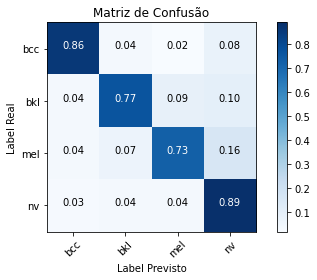

In [231]:
# Plot
plot_confusion_matrix(matriz, classes = classes, normalize = True ) 

In [232]:
# Relatório de Classificação
print(classification_report(Y_true_classes, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       100
           1       0.84      0.77      0.80       100
           2       0.83      0.73      0.78       100
           3       0.72      0.89      0.80       100

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400

